In [1]:
%matplotlib inline
import os

from pathlib import Path
from tensorflow.python.summary.summary_iterator import summary_iterator

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.errors import DataLossError

In [2]:
image_extension = 'pdf'

In [3]:
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [4]:
notebooks_dir = Path(os.path.abspath(''))
logs_dir = notebooks_dir.parent / 'hierarchical_algos' / 'logs'
logs_dagger_dir = notebooks_dir.parent / 'hierarchical_algos' / 'logsDagger'
media_dir = notebooks_dir.parent / 'media'

demos_log_dir = notebooks_dir.parent / 'hierarchical_algos' / 'demos' / 'logs'

new_logs_dir = notebooks_dir / 'data' / 'logs'

# Plotting functions

In [5]:
# This example supposes that the events file contains summaries with a
# summary value tag 'loss'.  These could have been added by calling
# `add_summary()`, passing the output of a scalar summary op created with
# with: `tf.scalar_summary(['loss'], loss_tensor)`.

def get_vals_with_tag(event_file_name, tag_name):
    values = []
    try:
        for index, e in enumerate(summary_iterator(event_file_name)):
            for v in e.summary.value:
                if v.tag == tag_name:
                    values.append(v.simple_value)
    except DataLossError as err:
        print(f"DataLossError: {err} - {len(values)} values were read")
        #print("DataLossError: {0}".format(err))
        #print(f"Stop reading new records and return the {len(values)} values that were read")
        #print("We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted")

    
    return values

def get_all_tags(event_file_name):
    tags = set()
    try:
        for index, e in enumerate(summary_iterator(event_file_name)):
            for v in e.summary.value:
                tags.add(v.tag)
    except DataLossError as err:
        print(f"DataLossError: {err} - {len(tags)} tags were read")
        #print(f"Stop reading new records and return the {len(tags)} tags that were read")
        #print("We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted")
            
    return tags

In [29]:
sns.set()
sns.set_style("whitegrid")

def make_running_rewards_plot(event_files, env_name, reward_threshold, algorithm, tag='Progress/Running reward', value='Running Reward', scaling_factor = 1, episode_spacing=1, maximum=None, fig_name=None):
    running_rewards_list = [get_vals_with_tag(event_file, tag) for event_file in event_files]
    display_running_rewards_plot(running_rewards_list, env_name, reward_threshold, algorithm, value, scaling_factor, episode_spacing, maximum, fig_name)
    
def display_running_rewards_plot(running_rewards_list, env_name, reward_threshold, algorithm, value, scaling_factor = 1, episode_spacing=1, maximum=None, fig_name=None, run_label=None):
    fig, ax = plt.subplots(figsize=(12, 6))#, constrained_layout=True)
    
    for index, running_rewards in enumerate(running_rewards_list):
        x = np.arange(min(len(running_rewards), 5000)) * episode_spacing 
        ax.plot(x, running_rewards[:5000], label=run_label or f"Run {index}")
        

    ax.set_xlabel("Episode")
    if scaling_factor == 1:
        ax.set_ylabel(f"{value}")
    else:
        ax.set_ylabel(f"{value} (scaling factor = {scaling_factor})")
        
    ax.set_title(f"Evolution of the {value} - {env_name} environment")
    
    if reward_threshold is not None:
        ax.axhline(y=reward_threshold, color='r', linestyle='-', label="Success threshold")
    elif maximum is not None:
        ax.axhline(y=maximum, color='r', linestyle='-', label="Maximum possible value")
        
    ax.legend()
    plt.tight_layout()
    #plt.constrained_layout()
    fig_name = fig_name or media_dir / f"{value}{env_name.replace(' ', '')}{algorithm}.{image_extension}"
    plt.savefig(fig_name) #, bbox_inches='tight')
    plt.show()

def display_percentage_reached_subgoals_plot(event_files, env_name, algorithm, smoothing_weight=0.6):
    subgoals_percentages_list = [get_vals_with_tag(event_file, 'Subgoals/Subgoal success') for event_file in event_files]

    def smooth(scalars, weight):  # Weight between 0 and 1
        last = scalars[0]  # First value in the plot (first timestep)
        smoothed = list()
        for point in scalars:
            smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
            smoothed.append(smoothed_val)                        # Save it
            last = smoothed_val                                  # Anchor the last smoothed value

        return smoothed
    
    
    plt.figure(figsize=(12, 6))
    for index, percentages in enumerate(subgoals_percentages_list):
        smoothed_percentages = smooth(percentages[:2000], smoothing_weight)
        plt.plot(smoothed_percentages, label=f"Run {index}")
        

    plt.xlabel("Episode")
    plt.ylabel("Smoothed percentage of subgoals that were reached")
    plt.title(f"Smoothed evolution of the percentage of subgoals that were reached - {env_name} environment")
    plt.legend()
    plt.savefig(media_dir / f"ReachedSubgoal{env_name.replace(' ', '')}{algorithm}.{image_extension}")
    plt.show()

def display_performance_plot(running_rewards_list, env_name, reward_threshold, algorithm, scaling_factor = 1, run_label=None, training=True, episode_multiplier=1, quantity=None):
    x = [i * episode_multiplier + 1 for i in range(len(running_rewards_list[0]))]
    
    plt.figure(figsize=(12, 6))
    for index, running_rewards in enumerate(running_rewards_list):
        plt.plot(x, running_rewards, label=run_label or f"Run {index}")
    
    

    plt.xlabel("Episode")
    if scaling_factor == 1:
        plt.ylabel(f"{quantity or 'Episode reward'}")
    else:
        plt.ylabel(f"{quantity or 'Episode reward'} (scaling factor = {scaling_factor})")
        
    train_str = "training" if training else "testing"
    
    plt.title(f"Episode reward during a {train_str} phase - {env_name} environment")
    plt.axhline(y=reward_threshold, color='r', linestyle='-', label="Success threshold")
    plt.legend()
    plt.tight_layout()
    plt.savefig(media_dir / f"EpisodeReward{env_name.replace(' ', '')}{algorithm}{train_str.capitalize()}.{image_extension}", dpi=300)
    plt.show()

# Old plots

In [153]:
lunar_lander_event_file1 = str(logs_dir / 'LunarLanderContinuous-v2' / 'May28_17-19-13' / 'events.out.tfevents.1590679155.thebox.1855205.0')
lunar_lander_event_file2 = str(logs_dir / 'LunarLanderContinuous-v2' / 'May28_19-13-32' / 'events.out.tfevents.1590686013.thebox.2105456.0')
lunar_lander_event_files = [lunar_lander_event_file1, lunar_lander_event_file2]

mountain_car_event_file1 = str(logs_dir / 'MountainCarContinuous-v0' / 'May30_01-23-42' / 'events.out.tfevents.1590794626.thebox.1200713.0')
mountain_car_event_files = [mountain_car_event_file1]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


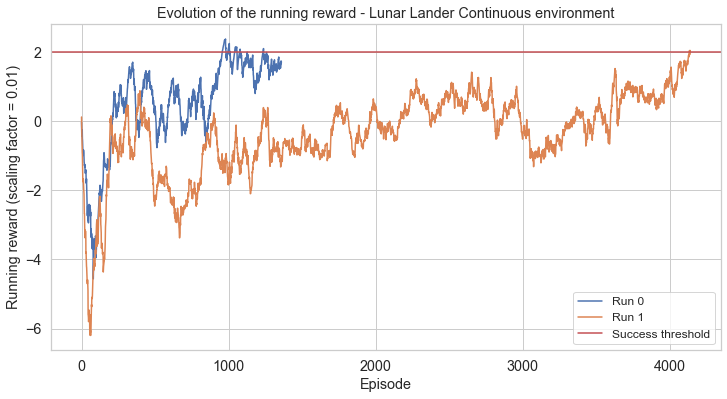

In [40]:
make_running_rewards_plot(
    lunar_lander_event_files, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=2, 
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=0.01
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


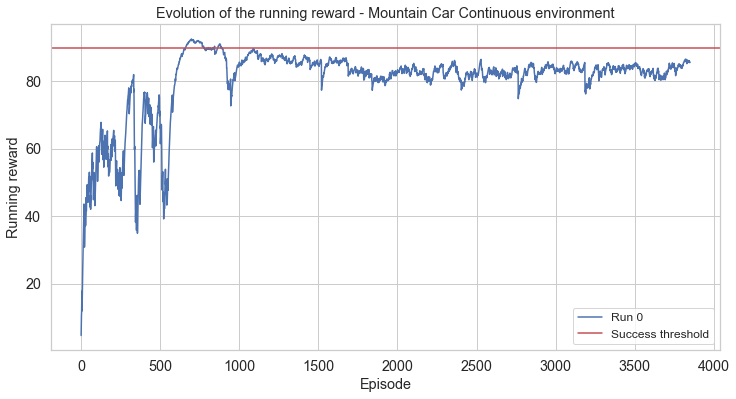

In [41]:
make_running_rewards_plot(
    mountain_car_event_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'HacGeneralWithTeacher',
)

## Stats about reaching the goal

In [106]:
demos_log_dir = notebooks_dir.parent / 'hierarchical_algos' / 'demos' / 'logs'

lunar_lander_demo_event_file = str(demos_log_dir / 'LunarLanderContinuous-v2' / 'Jul04_20-01-18' / 'events.out.tfevents.1593885681.thebox.2061222.0')
lunar_lander_demo_event_file = str(list(demos_log_dir.glob('**/LunarLanderContinuous-v2/Aug23_19-45-48*/*.0'))[0])
mountain_car_demo_event_file = str(list(demos_log_dir.glob('**/MountainCarContinuous-v0/Aug14_14-56*/*.0'))[0])

In [107]:
list(demos_log_dir.glob('**/LunarLanderContinuous-v2/Aug23_19*/*.0'))

[PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hierarchical_algos/demos/logs/LunarLanderContinuous-v2/Aug23_19-45-09/events.out.tfevents.1598204712.thebox.382178.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hierarchical_algos/demos/logs/LunarLanderContinuous-v2/Aug23_19-45-48/events.out.tfevents.1598204749.thebox.383662.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hierarchical_algos/demos/logs/LunarLanderContinuous-v2/Aug23_19-46-06/events.out.tfevents.1598204768.thebox.384338.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hierarchical_algos/demos/logs/LunarLanderContinuous-v2/Aug23_19-46-40/events.out.tfevents.1598204802.thebox.385579.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hierarchical_algos/demos/logs/LunarLanderContinuous-v2/Aug23_19-47-54/events.out.tfevents.1598204875.thebox.388240.0')]

In [108]:
percentage_subgoals_reached_mc = get_vals_with_tag(mountain_car_demo_event_file, 'Subgoals/Subgoal success')

In [109]:
percentage_subgoals_reached_ll = get_vals_with_tag(lunar_lander_demo_event_file, 'Subgoals/Subgoal success')

DataLossError: truncated record at 438281 - 13 values were read


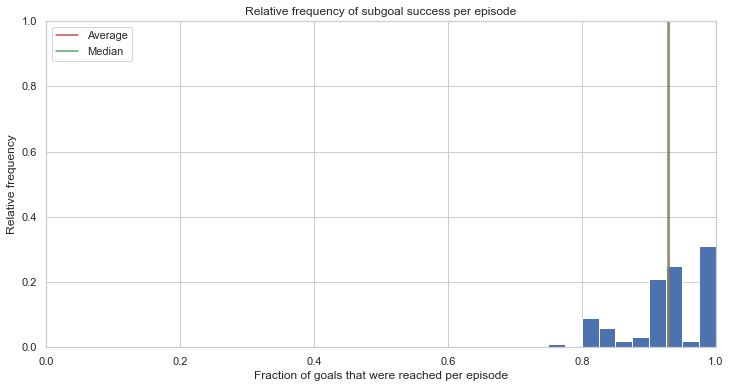

In [110]:
plt.figure(figsize=(12, 6))

def get_weights(data):
    return np.zeros_like(data) + 1. / len(data)

plt.hist(percentage_subgoals_reached_mc, weights=get_weights(percentage_subgoals_reached_mc))
plt.title('Relative frequency of subgoal success per episode')
plt.xlabel('Fraction of goals that were reached per episode')
plt.ylabel('Relative frequency')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axvline(np.average(percentage_subgoals_reached_mc), label='Average', color='r')
plt.axvline(np.median(percentage_subgoals_reached_mc), label='Median', color='g')
plt.legend()
plt.savefig(media_dir / f"SubgoalSuccessMountainCar.{image_extension}", dpi=300, bbox_inches='tight')

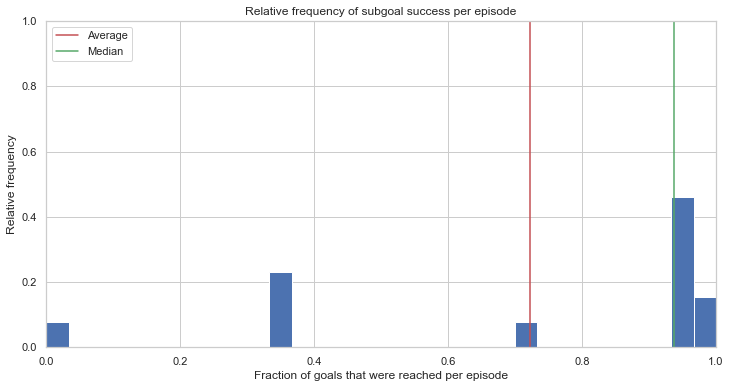

In [111]:
plt.figure(figsize=(12, 6))
plt.hist(percentage_subgoals_reached_ll, weights=get_weights(percentage_subgoals_reached_ll), bins=30)
plt.title('Relative frequency of subgoal success per episode')
plt.xlabel('Fraction of goals that were reached per episode')
plt.ylabel('Relative frequency')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axvline(np.mean(percentage_subgoals_reached_ll), label='Average', color='r')
plt.axvline(np.median(percentage_subgoals_reached_ll), label='Median', color='g')
plt.legend()
plt.savefig(media_dir / f"SubgoalSuccesLunarLander.{image_extension}", dpi=300, bbox_inches='tight')

## No teacher

In [673]:
lunar_lander_no_teacher_demo_event_file = str(list(demos_log_dir.glob('**/LunarLanderContinuous-v2/Aug23*/*.0'))[1])
mountain_car_no_teacher_demo_event_file = str(list(demos_log_dir.glob('**/MountainCarContinuous-v0/Aug23_16-31-56/*.0'))[0])

In [677]:
percentage_subgoals_reached_mc_no_teacher = get_vals_with_tag(mountain_car_no_teacher_demo_event_file, 'Subgoals/Subgoal success')
percentage_subgoals_reached_ll_no_teacher = get_vals_with_tag(lunar_lander_no_teacher_demo_event_file, 'Subgoals/Subgoal success')

In [681]:
percentage_subgoals_reached_mc_no_teacher[:10]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

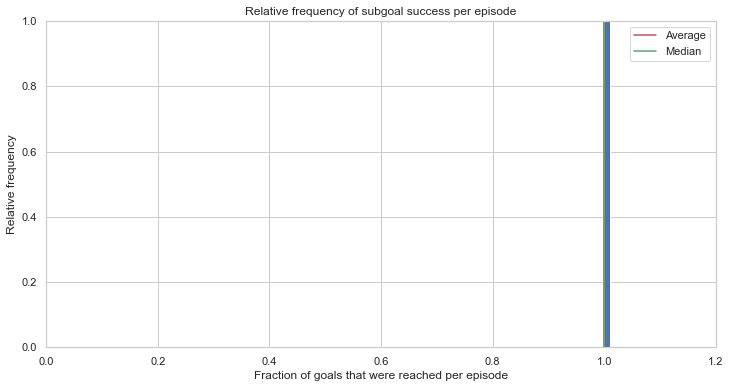

In [685]:
plt.figure(figsize=(12, 6))
plt.hist(percentage_subgoals_reached_mc_no_teacher, weights=get_weights(percentage_subgoals_reached_mc_no_teacher), bins=100)
plt.title('Relative frequency of subgoal success per episode')
plt.xlabel('Fraction of goals that were reached per episode')
plt.ylabel('Relative frequency')
plt.xlim(0, 1.2)
plt.ylim(0, 1)
plt.axvline(np.average(percentage_subgoals_reached_mc_no_teacher), label='Average', color='r')
plt.axvline(np.median(percentage_subgoals_reached_mc_no_teacher), label='Median', color='g')
plt.legend()
plt.savefig(media_dir / f"SubgoalSuccessMountainCarWithoutTeacher.{image_extension}", dpi=300, bbox_inches='tight')

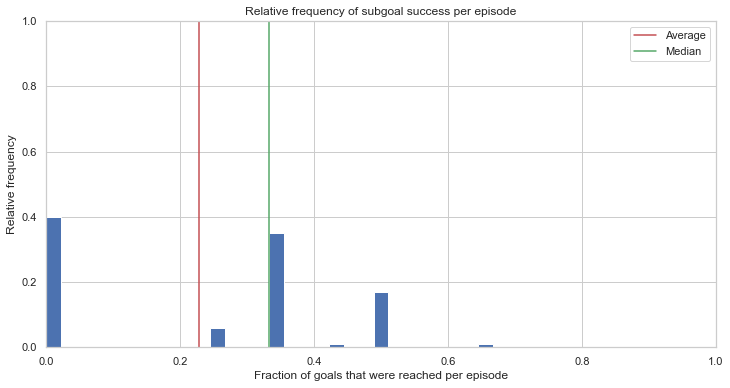

In [686]:
plt.figure(figsize=(12, 6))
plt.hist(percentage_subgoals_reached_ll_no_teacher, weights=get_weights(percentage_subgoals_reached_ll_no_teacher), bins=30)
plt.title('Relative frequency of subgoal success per episode')
plt.xlabel('Fraction of goals that were reached per episode')
plt.ylabel('Relative frequency')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axvline(np.mean(percentage_subgoals_reached_ll_no_teacher), label='Average', color='r')
plt.axvline(np.median(percentage_subgoals_reached_ll_no_teacher), label='Median', color='g')
plt.legend()
plt.savefig(media_dir / f"SubgoalSuccessLunarLanderWithoutTeacher.{image_extension}", dpi=300, bbox_inches='tight')

In [47]:
np.mean(percentage_subgoals_reached_mc)

0.9745216846820854

In [48]:
print(len(percentage_subgoals_reached_mc))

336


In [49]:
np.mean(percentage_subgoals_reached_ll)

0.7034615315925116

In [50]:
print(len(percentage_subgoals_reached_ll))

696


# HAC-General (without Teacher)

In [51]:
lunar_lander_no_teacher_event_file_1 = str(logs_dir / 'LunarLanderContinuous-v2' / 'Jun20_01-56-07' / 'events.out.tfevents.1592610968.thebox.2211291.0')
lunar_lander_no_teacher_event_file_2 = str(logs_dir / 'LunarLanderContinuous-v2' / 'Jun20_14-35-39' / 'events.out.tfevents.1592656542.thebox.3264987.0')
lunar_lander_no_teacher_event_files = [lunar_lander_no_teacher_event_file_1, lunar_lander_no_teacher_event_file_2]

mountain_car_no_teacher_event_file_1 = str(logs_dir / 'MountainCarContinuous-v0' / 'Jun21_23-02-22' / 'events.out.tfevents.1592773345.thebox.2029788.0')
mountain_car_no_teacher_event_file_2 = str(logs_dir / 'MountainCarContinuous-v0' / 'Jun23_10-55-01' / 'events.out.tfevents.1592902504.thebox.448039.0')
mountain_car_no_teacher_event_files = [mountain_car_no_teacher_event_file_1, mountain_car_no_teacher_event_file_2]

DataLossError: truncated record at 212699621
Stop reading new records and return the 5709 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


DataLossError: truncated record at 265980051
Stop reading new records and return the 5811 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


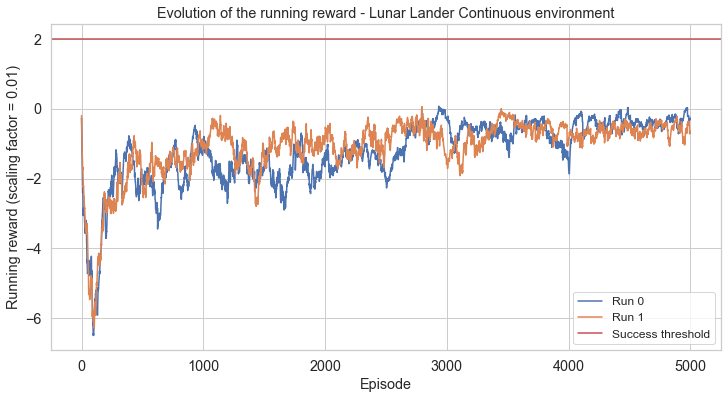

In [52]:
make_running_rewards_plot(
    lunar_lander_no_teacher_event_files, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=2, 
    algorithm = 'HacGeneralWithoutTeacher',
    scaling_factor=0.01
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


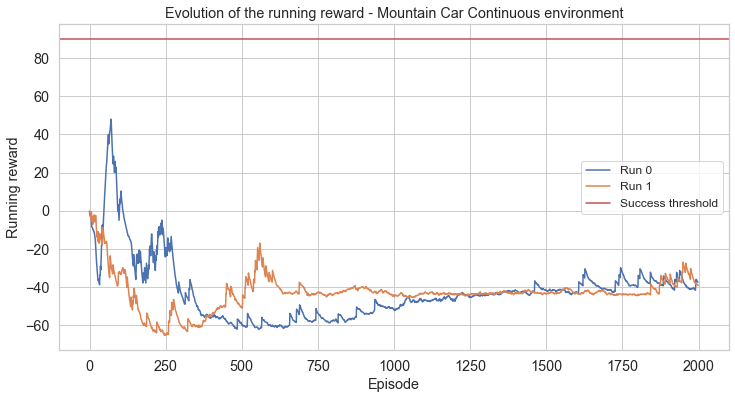

In [53]:
make_running_rewards_plot(
    mountain_car_no_teacher_event_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'HacGeneralWithoutTeacher',
)

DataLossError: truncated record at 212699621
Stop reading new records and return the 6665 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted
DataLossError: truncated record at 265980051
Stop reading new records and return the 6781 values that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


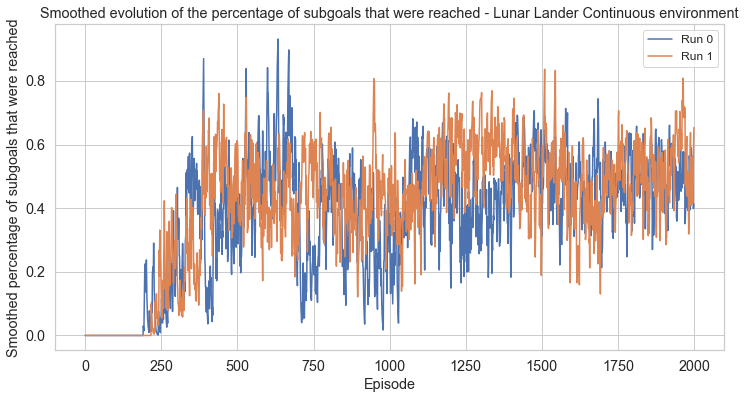

In [54]:
display_percentage_reached_subgoals_plot(
    lunar_lander_no_teacher_event_files, 
    env_name='Lunar Lander Continuous', 
    algorithm = 'HacGeneralWithoutTeacher',
    smoothing_weight=0.7
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


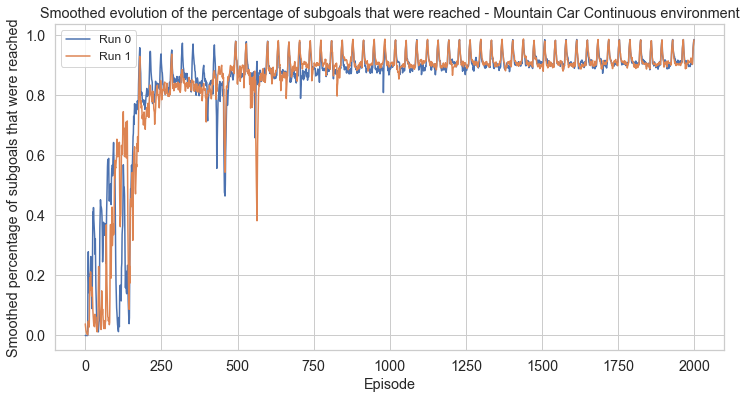

In [55]:
display_percentage_reached_subgoals_plot(
    mountain_car_no_teacher_event_files, 
    env_name='Mountain Car Continuous', 
    algorithm = 'HacGeneralWithoutTeacher',
    smoothing_weight=0.7
)

In [56]:
get_all_tags(lunar_lander_no_teacher_event_files[0])

DataLossError: truncated record at 212699621
Stop reading new records and return the 56 tags that were read
We assume the record got truncated because I did Ctrl-C to stop the process and the I/O was interrupted


{'Action/(Level 0) 0 ',
 'Action/(Level 0) 1 ',
 'Action/Predicted reward (Level 1)',
 'Eval/Mean number of steps',
 'Eval/Mean reward',
 'Eval/Std dev number of steps',
 'Eval/Success rate',
 'Level 0/Done',
 'Level 0/Failed to reach goal',
 'Level 0/Steps per episode',
 'Level 0/Total reward',
 'Level 1/Done',
 'Level 1/Steps per episode',
 'Level 1/Total reward',
 'Loss/(Level 0) Log Prob',
 'Loss/(Level 0) Policy',
 'Loss/(Level 0) Predicted 1',
 'Loss/(Level 0) Predicted 2',
 'Loss/(Level 0) Reward',
 'Loss/(Level 0) Target',
 'Loss/(Level 0) Value',
 'Loss/(Level 0) Values 1',
 'Loss/(Level 0) Values 2',
 'Loss/(Level 1) Log Prob',
 'Loss/(Level 1) Policy',
 'Loss/(Level 1) Predicted 1',
 'Loss/(Level 1) Predicted 2',
 'Loss/(Level 1) Reward',
 'Loss/(Level 1) Target',
 'Loss/(Level 1) Value',
 'Loss/(Level 1) Values 1',
 'Loss/(Level 1) Values 2',
 'Progress/Episode reward',
 'Progress/Num episodes steps',
 'Progress/Running reward',
 'Q-values/Normal (Level 0) Network 1',
 'Q-v

# Dagger

In [31]:
lunar_lander_event_file_dagger = str(logs_dagger_dir / 'LunarLanderContinuous-v2' / 'Jun15_23-40-22' / 'events.out.tfevents.1592257223.thebox.2492523.0')
lunar_lander_event_files_dagger = [lunar_lander_event_file_dagger]
lunar_lander_event_file_dagger

'/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hierarchical_algos/logsDagger/LunarLanderContinuous-v2/Jun15_23-40-22/events.out.tfevents.1592257223.thebox.2492523.0'

In [32]:
get_all_tags(lunar_lander_event_file_dagger)

{'TestingPhase/Episode reward',
 'TestingPhase/Eval Mean Num Steps',
 'TestingPhase/Eval Mean Percent goals reached',
 'TestingPhase/Eval Mean Reward',
 'TestingPhase/Eval Std Dev Num Steps',
 'TestingPhase/Eval Std Dev Reward',
 'TestingPhase/Eval Std Percent goals reached',
 'TestingPhase/Percent goals reached',
 'TestingPhase/Steps in episode',
 'TrainingPhase/Episode reward',
 'TrainingPhase/Eval Mean Num Steps',
 'TrainingPhase/Eval Mean Percent goals reached',
 'TrainingPhase/Eval Mean Reward',
 'TrainingPhase/Eval Std Dev Num Steps',
 'TrainingPhase/Eval Std Dev Reward',
 'TrainingPhase/Eval Std Percent goals reached',
 'TrainingPhase/Percent goals reached',
 'TrainingPhase/Steps in episode'}

In [33]:
running_rewards_list = [get_vals_with_tag(event_file, 'TestingPhase/Episode reward') for event_file in lunar_lander_event_files_dagger]
running_rewards_list;

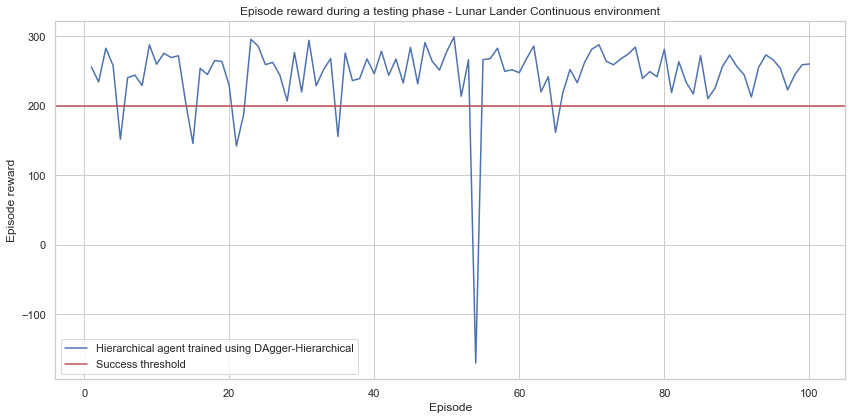

In [34]:
display_performance_plot(
    running_rewards_list, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=200, 
    algorithm = 'DAgger-Hierarchical',
    run_label = "Hierarchical agent trained using DAgger-Hierarchical",
    training = False
)

In [35]:
running_rewards_list_train = [get_vals_with_tag(event_file, 'TrainingPhase/Eval Mean Reward') for event_file in lunar_lander_event_files_dagger]
running_rewards_list_train;

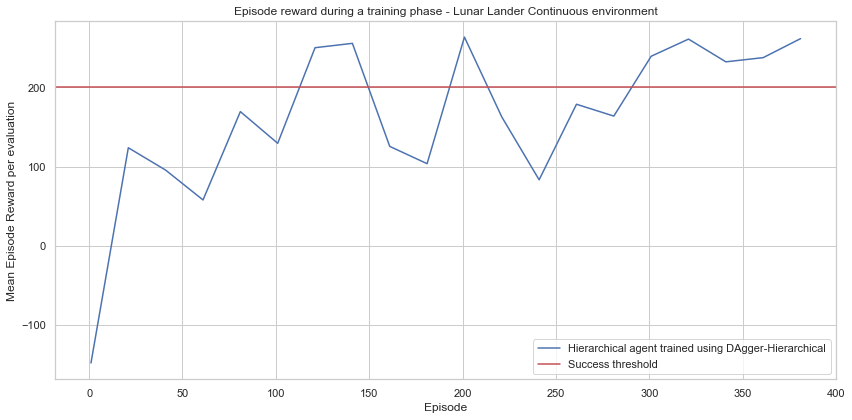

In [36]:
display_performance_plot(
    running_rewards_list_train, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=200, 
    algorithm = 'DAgger-Hierarchical',
    run_label = "Hierarchical agent trained using DAgger-Hierarchical",
    quantity = "Mean Episode Reward per evaluation",
    episode_multiplier = 20,
    training = True
)

# New stats from cluster

## Mountain Car - with teacher

In [7]:
mountain_car_files_paths = list(new_logs_dir.glob('**/MountainCarContinuous-v0/Aug02_15*/*.0'))
mountain_car_files_paths

[PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug02_15-02-17/events.out.tfevents.1596373339.node379.hydra.os.265280.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug02_15-02-38/events.out.tfevents.1596373360.node379.hydra.os.17544.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug02_15-02-59/events.out.tfevents.1596373381.node379.hydra.os.84094.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug02_15-03-23/events.out.tfevents.1596373405.node378.hydra.os.90620.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug02_15-03-41/events.out.tfevents.1596373423.node376.hydra.os.301184.0')]

In [8]:
mountain_car_files = [str(path) for path in mountain_car_files_paths]

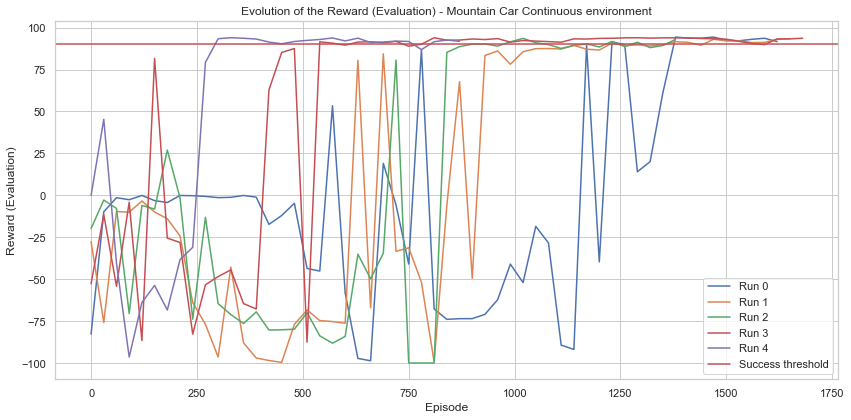

In [11]:
make_running_rewards_plot(
    mountain_car_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=1,
    tag='Eval/Mean_reward',
    value='Reward (Evaluation)',
    episode_spacing=30
    #tag='Progress/Running_reward'
)

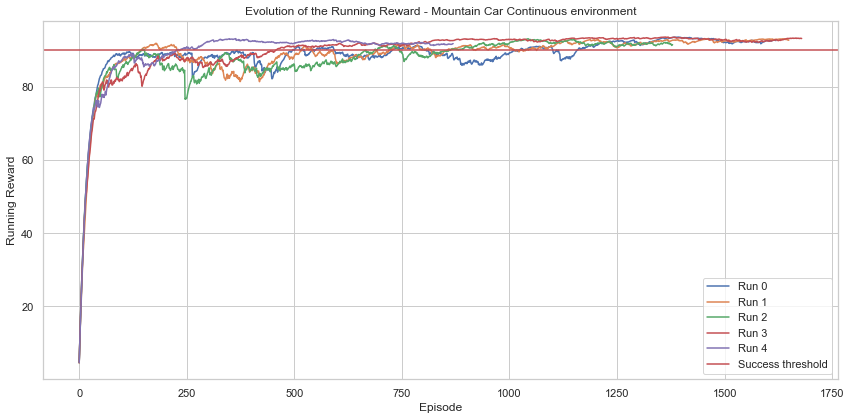

In [12]:
make_running_rewards_plot(
    mountain_car_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=1,
    #tag='Eval/Mean_reward'
    tag='Progress/Running_reward',
    value='Running Reward'
)

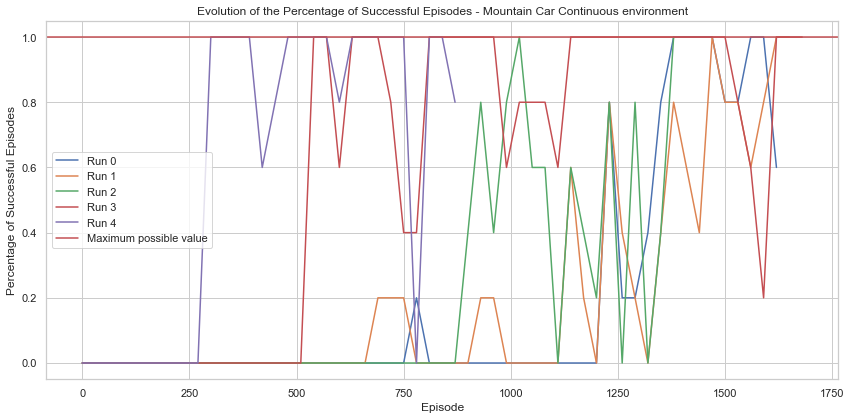

In [13]:
make_running_rewards_plot(
    mountain_car_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=None, 
    maximum=1.0,
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=1,
    tag='Eval/Success_rate',    
    value='Percentage of Successful Episodes',
    episode_spacing=30
)

## Mountain Car - without teacher

In [14]:
mountain_car_no_teacher_files_paths = list(new_logs_dir.glob('**/MountainCarContinuous-v0/Aug04*/*.0'))
mountain_car_no_teacher_files_paths

[PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug04_19-51-26/events.out.tfevents.1596563521.node225.hydra.os.26527.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug04_19-51-26/events.out.tfevents.1596563521.node225.hydra.os.26549.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug04_19-54-24/events.out.tfevents.1596563670.node379.hydra.os.149735.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug04_19-54-24/events.out.tfevents.1596563670.node379.hydra.os.156110.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/MountainCarContinuous-v0/Aug04_19-54-24/events.out.tfevents.1596563670.node379.hydra.os.160257.0')]

In [15]:
mountain_car_no_teacher_files = [str(path) for path in mountain_car_no_teacher_files_paths]

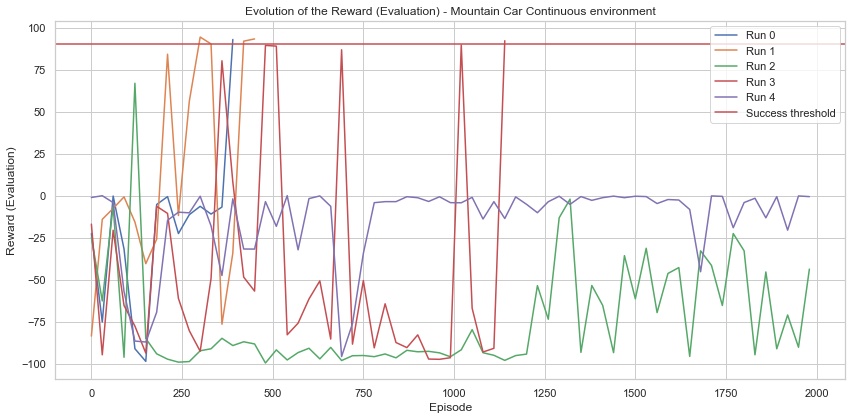

In [16]:
make_running_rewards_plot(
    mountain_car_no_teacher_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'HacGeneralWithoutTeacher',
    scaling_factor=1,
    tag='Eval/Mean_reward',
    value='Reward (Evaluation)',
    episode_spacing=30
)

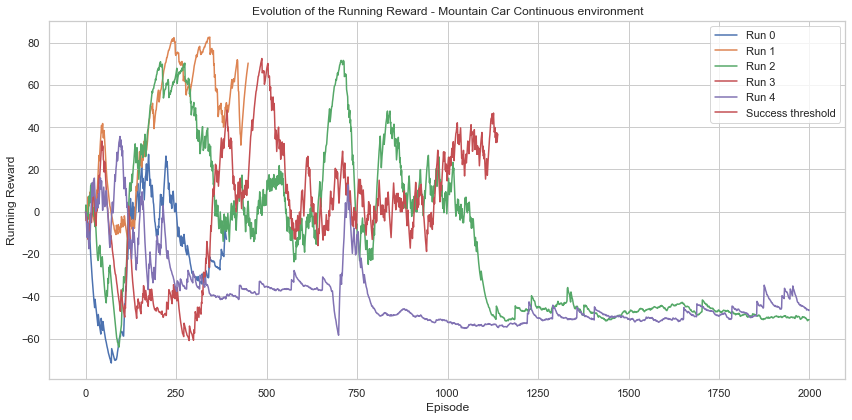

In [17]:
make_running_rewards_plot(
    mountain_car_no_teacher_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'HacGeneralWithoutTeacher',
    scaling_factor=1,
    tag='Progress/Running_reward',
    value='Running Reward'
)

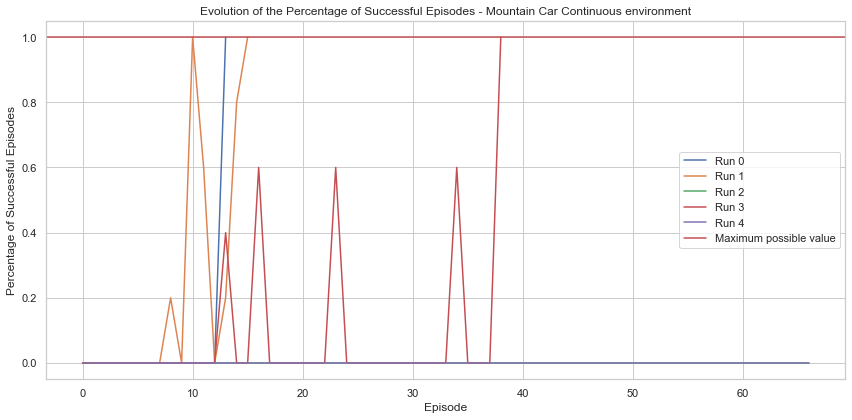

In [18]:
make_running_rewards_plot(
    mountain_car_no_teacher_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=None, 
    maximum=1.0,
    algorithm = 'HacGeneralWithoutTeacher',
    scaling_factor=1,
    tag='Eval/Success_rate',
    value='Percentage of Successful Episodes'
)

## Lunar Lander - with teacher

In [19]:
lunar_lander_files_paths0 = list(new_logs_dir.glob('**/LunarLanderContinuous-v2/Aug08*/*.0'))
#lunar_lander_files_paths = list(new_logs_dir.glob('**/LunarLanderContinuous-v2/Aug14_15*/*.0'))
#lunar_lander_files_paths1 = list(new_logs_dir.glob('**/LunarLanderContinuous-v2/Aug14_22*/*.0'))
#lunar_lander_files_paths2 = list(new_logs_dir.glob('**/LunarLanderContinuous-v2/Aug14_23*/*.0')) + list(new_logs_dir.glob('**/LunarLanderContinuous-v2/Aug15_00*/*.0'))
lunar_lander_files_paths3 = list(new_logs_dir.glob('**/LunarLanderContinuous-v2/Aug15_14*/*.0'))
lunar_lander_files_paths4 = list(new_logs_dir.glob('**/LunarLanderContinuous-v2/Aug15_18*/*.0'))
lunar_lander_files_paths5 = list(new_logs_dir.glob('**/LunarLanderContinuous-v2/Aug16*/*.0'))
lunar_lander_files_paths5

[PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug16_15-18-29-19094/events.out.tfevents.1597584221.node355.hydra.os.289274.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug16_15-18-29-5979/events.out.tfevents.1597584221.node355.hydra.os.289284.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug16_15-19-08-40330/events.out.tfevents.1597584259.node353.hydra.os.24717.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug16_15-19-08-78342/events.out.tfevents.1597584259.node353.hydra.os.24707.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug16_16-09-01-60504/events.out.tfevents.1597587170.node352.hydra.os.

In [20]:
#relevant_lunar_lander_files_paths = [lunar_lander_files_paths4, lunar_lander_files_paths5]
relevant_lunar_lander_files_paths = [lunar_lander_files_paths5]
#relevant_lunar_lander_files_paths = [lunar_lander_files_paths5]
lunar_lander_files_list = [[str(path) for path in lunar_lander_files_paths] 
                           for lunar_lander_files_paths 
                           in relevant_lunar_lander_files_paths]
lunar_lander_files_list

[['/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug16_15-18-29-19094/events.out.tfevents.1597584221.node355.hydra.os.289274.0',
  '/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug16_15-18-29-5979/events.out.tfevents.1597584221.node355.hydra.os.289284.0',
  '/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug16_15-19-08-40330/events.out.tfevents.1597584259.node353.hydra.os.24717.0',
  '/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug16_15-19-08-78342/events.out.tfevents.1597584259.node353.hydra.os.24707.0',
  '/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug16_16-09-01-60504/events.out.tfevents.1597587170.node352.hydra.os.229574.0']]

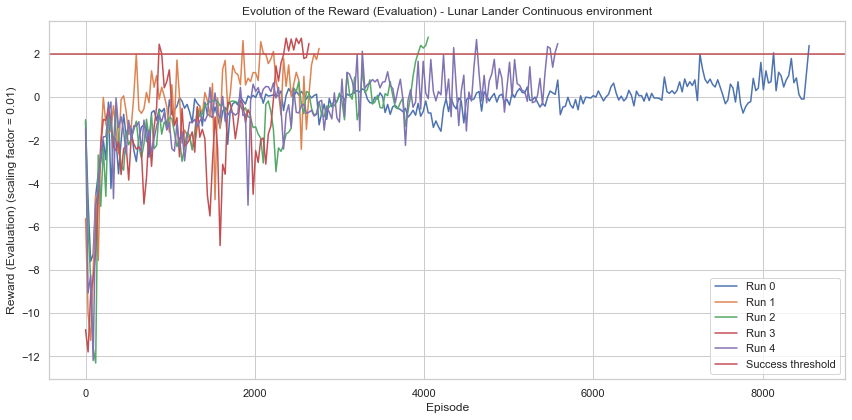

In [21]:
for lunar_lander_files in lunar_lander_files_list:
    make_running_rewards_plot(
        lunar_lander_files, 
        env_name='Lunar Lander Continuous', 
        reward_threshold=2, 
        algorithm = 'HacGeneralWithTeacher',
        scaling_factor=0.01,
        tag='Eval/Mean_reward',
        episode_spacing = 30,
        value = 'Reward (Evaluation)'
    )

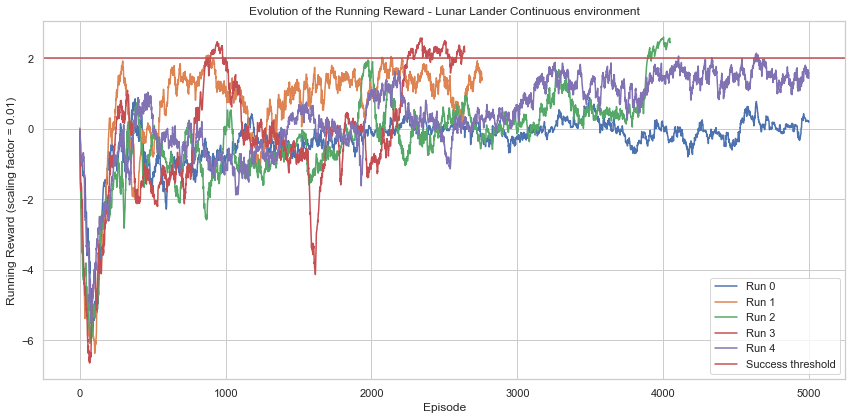

In [22]:
for lunar_lander_files in lunar_lander_files_list:
    make_running_rewards_plot(
        lunar_lander_files, 
        env_name='Lunar Lander Continuous', 
        reward_threshold=2, 
        algorithm = 'HacGeneralWithTeacher',
        scaling_factor=0.01,
        tag='Progress/Running_reward',
        value='Running Reward'
    )

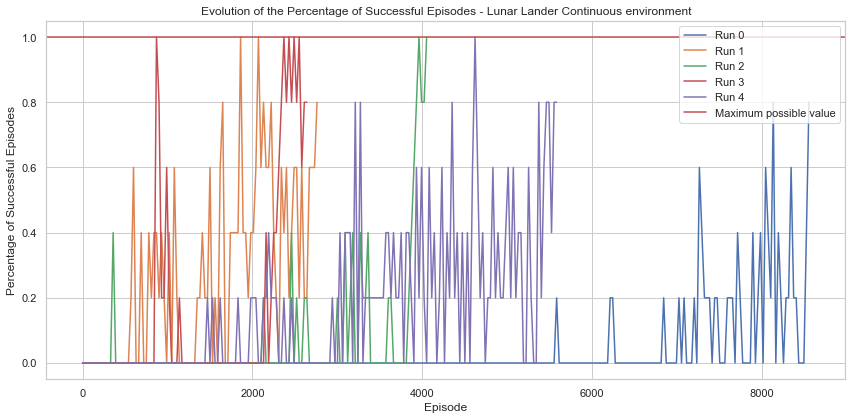

In [23]:
for lunar_lander_files in lunar_lander_files_list:
    make_running_rewards_plot(
        lunar_lander_files, 
        env_name='Lunar Lander Continuous', 
        reward_threshold=None,
        maximum=1.0,
        algorithm = 'HacGeneralWithTeacher',
        scaling_factor=1,
        tag='Eval/Success_rate',
        episode_spacing=30,
        value='Percentage of Successful Episodes'
    )
    
# Graph 1 (now not displaying) - Current changes: new model and SAC With Entropy

## Lunar Lander - without teacher

In [24]:
lunar_lander_files_no_teacher_paths = list(new_logs_dir.glob('**/LunarLanderContinuous-v2/Aug17*/*.0'))
lunar_lander_files_no_teacher_paths

[PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug17_18-54-02-19094/events.out.tfevents.1597683697.node363.hydra.os.246377.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug17_19-21-41-5979/events.out.tfevents.1597685107.node363.hydra.os.239330.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug17_19-32-32-78342/events.out.tfevents.1597685564.node353.hydra.os.37199.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug17_20-37-23-40330/events.out.tfevents.1597689449.node363.hydra.os.274335.0'),
 PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug17_20-59-40-60504/events.out.tfevents.1597690952.node377.hydra.os

In [25]:
#relevant_lunar_lander_files_paths = [lunar_lander_files_paths4, lunar_lander_files_paths5]
relevant_lunar_lander_files_no_teacher_paths = [lunar_lander_files_no_teacher_paths]
#relevant_lunar_lander_files_paths = [lunar_lander_files_paths5]
lunar_lander_no_teacher_files_list = [[str(path) for path in lunar_lander_files_paths] 
                           for lunar_lander_files_paths 
                           in relevant_lunar_lander_files_no_teacher_paths]
lunar_lander_no_teacher_files_list

[['/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug17_18-54-02-19094/events.out.tfevents.1597683697.node363.hydra.os.246377.0',
  '/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug17_19-21-41-5979/events.out.tfevents.1597685107.node363.hydra.os.239330.0',
  '/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug17_19-32-32-78342/events.out.tfevents.1597685564.node353.hydra.os.37199.0',
  '/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug17_20-37-23-40330/events.out.tfevents.1597689449.node363.hydra.os.274335.0',
  '/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/notebooks/data/logs/LunarLanderContinuous-v2/Aug17_20-59-40-60504/events.out.tfevents.1597690952.node377.hydra.os.177257.0']]

DataLossError: truncated record at 234608868 - 311 values were read
DataLossError: truncated record at 233208826 - 316 values were read


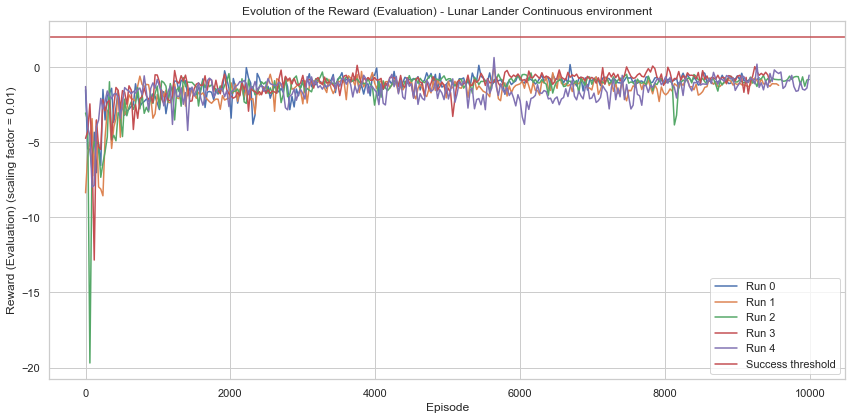

In [26]:
for lunar_lander_files in lunar_lander_no_teacher_files_list:
    make_running_rewards_plot(
        lunar_lander_files, 
        env_name='Lunar Lander Continuous', 
        reward_threshold=2, 
        algorithm = 'HacGeneralWithoutTeacher',
        scaling_factor=0.01,
        tag='Eval/Mean_reward',
        episode_spacing = 30,
        value = 'Reward (Evaluation)'
    )

DataLossError: truncated record at 234608868 - 9322 values were read
DataLossError: truncated record at 233208826 - 9473 values were read


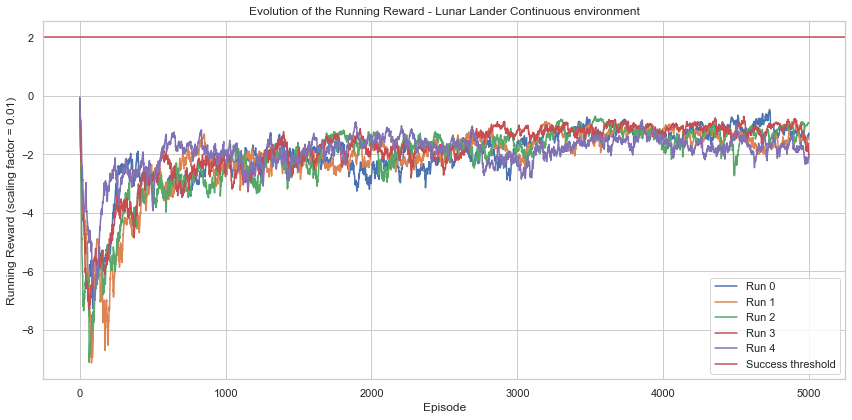

In [27]:
for lunar_lander_files in lunar_lander_no_teacher_files_list:
    make_running_rewards_plot(
        lunar_lander_files, 
        env_name='Lunar Lander Continuous', 
        reward_threshold=2, 
        algorithm = 'HacGeneralWithoutTeacher',
        scaling_factor=0.01,
        tag='Progress/Running_reward',
        value='Running Reward'
    )

DataLossError: truncated record at 234608868 - 311 values were read
DataLossError: truncated record at 233208826 - 316 values were read


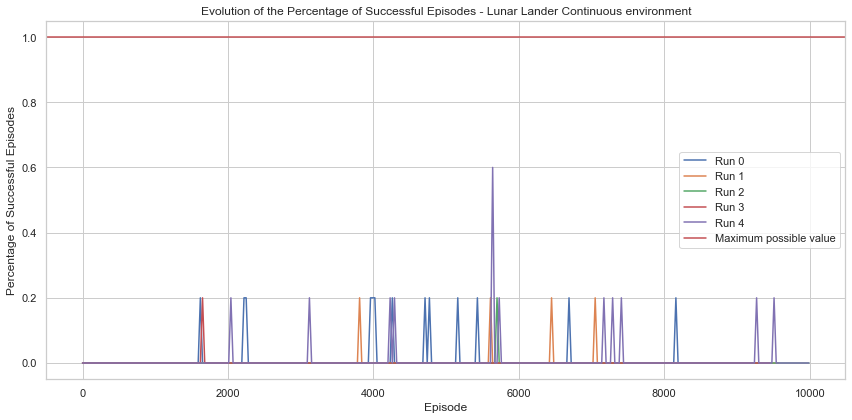

In [28]:
for lunar_lander_files in lunar_lander_no_teacher_files_list:
    make_running_rewards_plot(
        lunar_lander_files, 
        env_name='Lunar Lander Continuous', 
        reward_threshold=None, 
        maximum=1.0,
        algorithm = 'HacGeneralWithoutTeacher',
        scaling_factor=1,
        tag='Eval/Success_rate',
        episode_spacing=30,
        value='Percentage of Successful Episodes'
    )
    
# Graph 1 (now not displaying) - Current changes: new model and SAC With Entropy

# HAC

## Mountain Car

In [118]:
hac_logs_dir = notebooks_dir.parent / 'hierarchical_algos' / 'logs'

In [120]:
mountain_car_files_paths = list(hac_logs_dir.glob('**/MountainCarContinuous-v0/Aug14_16*/*.0'))
mountain_car_files_paths

[PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hierarchical_algos/logs/MountainCarContinuous-v0/Aug14_16-15-40/events.out.tfevents.1597414541.thebox.3996420.0')]

In [122]:
mountain_car_files = [str(path) for path in mountain_car_files_paths]
mountain_car_files

['/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hierarchical_algos/logs/MountainCarContinuous-v0/Aug14_16-15-40/events.out.tfevents.1597414541.thebox.3996420.0']

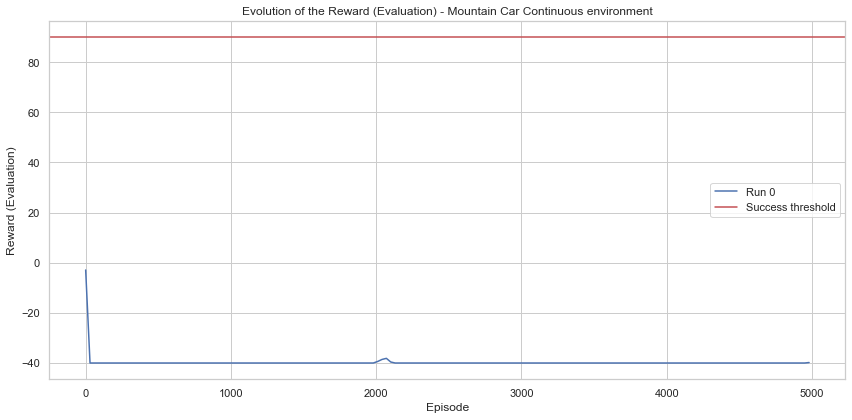

In [125]:
make_running_rewards_plot(
    mountain_car_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'Hac',
    scaling_factor=1,
    tag='Eval/Mean Reward',
    value='Reward (Evaluation)',
    episode_spacing=30
    #tag='Progress/Running_reward'
)

## Lunar Lander

In [128]:
lunar_lander_files_paths = list(hac_logs_dir.glob('**/LunarLanderContinuous-v2/Aug15*/*.0'))
lunar_lander_files_paths

[PosixPath('/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hierarchical_algos/logs/LunarLanderContinuous-v2/Aug15_16-58-20/events.out.tfevents.1597503506.thebox.1443381.0')]

In [129]:
lunar_lander_files = [str(path) for path in lunar_lander_files_paths]
lunar_lander_files

['/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hierarchical_algos/logs/LunarLanderContinuous-v2/Aug15_16-58-20/events.out.tfevents.1597503506.thebox.1443381.0']

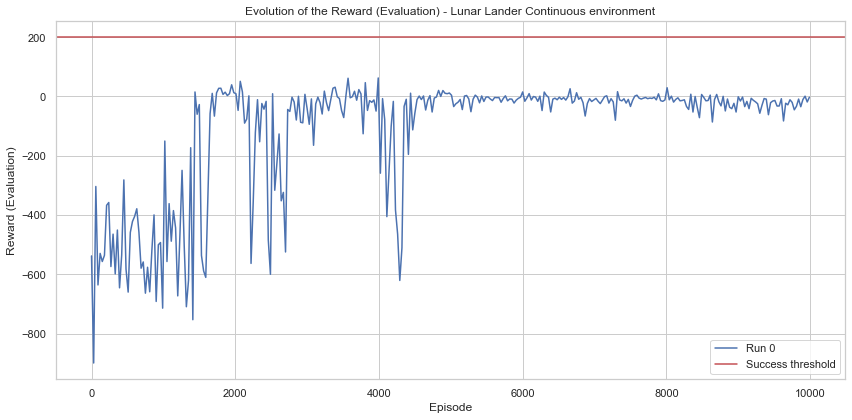

In [131]:
make_running_rewards_plot(
    lunar_lander_files, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=200, 
    algorithm = 'Hac',
    scaling_factor=1,
    tag='Eval/Mean Reward',
    value='Reward (Evaluation)',
    episode_spacing=30
    #tag='Progress/Running_reward'
)

# Others

## Fast time estimation

In [562]:
episode_rate = 90 / 20.0  # 90 episodes in 20 minutes
episode_rate

4.5

In [22]:
total_number_episodes = 1000

In [24]:
num_minutes = total_number_episodes / episode_rate
num_minutes

222.22222222222223

In [32]:
def print_time(num_minutes):
    hours = int(num_minutes // 60)
    minutes = num_minutes % 60
    print(f"{hours:} hours and {minutes:.1f} minutes to execute {total_number_episodes} episodes")

print_time(num_minutes)

3 hours and 42.2 minutes to execute 1000 episodes


We will be save and do a 3x slowdown, since it's often much slower as the training progresses.
This makes it about 10 hours

In [33]:
print_time(num_minutes * 3)

11 hours and 6.7 minutes to execute 1000 episodes


That's roughly eleven hours!